In [19]:
import gym
from gym import spaces
import numpy as np
# Environment definition remains unchanged
class RoomTemperatureControlEnv(gym.Env):
    def __init__(self, noise_int=0.5, noise_ext=0.5, k=1.0):
        super(RoomTemperatureControlEnv, self).__init__()
        self.insulation_factor = 0.1
        self.temperature_setpoint = 26.0
        self.action_space = spaces.Discrete(2)  # +0.1 or -0.1
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf]),
            high=np.array([np.inf, np.inf]),
            dtype=np.float32
        )
        self.state = None
        self.noise_int = noise_int
        self.noise_ext = noise_ext
        self.k = k

    def reset(self):
        self.state = np.array([15.0, self.external_temperature(0)], dtype=np.float32)
        self.time = 0
        return self._get_obs()

    def step(self, action):
        action_value = 0.1 if action == 1 else -0.1
        internal_temp, external_temp = self.state
        if internal_temp < external_temp and action_value < 0:
            action_value = 0.0  # Prevent temperature from decreasing if below external temperature
        internal_temp += self.insulation_factor * (external_temp - internal_temp) + action_value
        self.time += 1
        self.state = np.array([internal_temp, self.external_temperature(self.time)], dtype=np.float32)
        done = self.time >= 1440
        distance_from_external = internal_temp - external_temp
        time_penalty = self.k * np.log(self.time + 1)
        reward = - abs(distance_from_external + time_penalty)  # Penalize deviation from setpoint
        return self._get_obs(), reward, done, {}

    def external_temperature(self, t):
        return 20 + 10 * np.sin(2 * np.pi * t / (24 * 60))

    def _get_obs(self):
        internal_temp, external_temp = self.state
        noise_int = np.random.normal(0, self.noise_int)
        noise_ext = np.random.normal(0, self.noise_ext)
        return np.array([internal_temp + noise_int, external_temp + noise_ext], dtype=np.float32)

# Assuming the DQNAgent class and other necessary components are defined

In [25]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)[0]).item())
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(state))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Training the DQN model
env = RoomTemperatureControlEnv()  # Ensure your environment is set correctly
agent = DQNAgent(state_size=2, action_size=2)
done = False
batch_size = 32
EPISODES = 50

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0
    for time in range(1440):  # One day simulation
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e+1}/{EPISODES}, total reward: {total_reward:.2f}, epsilon: {agent.epsilon:.2f}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


episode: 1/50, total reward: -9097.72, epsilon: 0.10
episode: 2/50, total reward: -9313.87, epsilon: 0.10
episode: 3/50, total reward: -9235.06, epsilon: 0.10
episode: 4/50, total reward: -9014.01, epsilon: 0.10
episode: 5/50, total reward: -9104.51, epsilon: 0.10
episode: 6/50, total reward: -9074.12, epsilon: 0.10
episode: 7/50, total reward: -9112.97, epsilon: 0.10
episode: 8/50, total reward: -9242.39, epsilon: 0.10
episode: 9/50, total reward: -9238.39, epsilon: 0.10
episode: 10/50, total reward: -9270.13, epsilon: 0.10
episode: 11/50, total reward: -9165.89, epsilon: 0.10
episode: 12/50, total reward: -9348.71, epsilon: 0.10
episode: 13/50, total reward: -8987.20, epsilon: 0.10
episode: 14/50, total reward: -9296.20, epsilon: 0.10
episode: 15/50, total reward: -9269.80, epsilon: 0.10
episode: 16/50, total reward: -9361.38, epsilon: 0.10
episode: 17/50, total reward: -9153.99, epsilon: 0.10
episode: 18/50, total reward: -9162.67, epsilon: 0.10
episode: 19/50, total reward: -9286.5

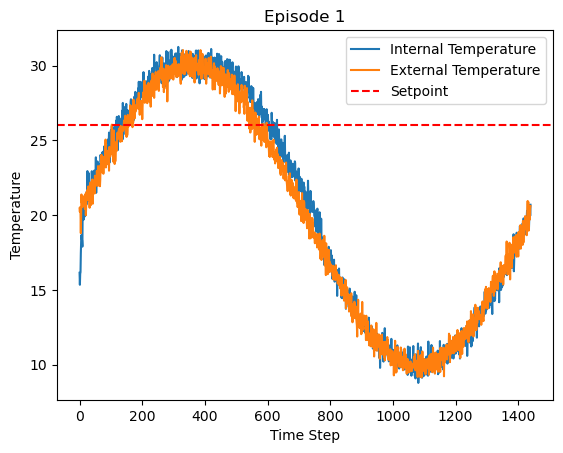

In [31]:
import matplotlib.pyplot as plt

# Function to track and plot the internal and external temperatures
def track_temperature(agent, env, episodes=1):
    for episode in range(episodes):
        state = env.reset()
        done = False
        internal_temps = []
        external_temps = []
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            internal_temps.append(next_state[0])  # Assuming the first element is the internal temperature
            external_temps.append(next_state[1])  # Assuming the second element is the external temperature
            state = next_state

        plt.plot(internal_temps, label='Internal Temperature')
        plt.plot(external_temps, label='External Temperature')
        plt.axhline(y=env.temperature_setpoint, color='r', linestyle='--', label='Setpoint')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature')
        plt.title(f'Episode {episode + 1}')
        plt.legend()
        plt.show()

# Example usage:
track_temperature(agent, env, episodes=1)
